## Data loading

Making sure to split into sequences and using class labeling

Processing circle data from /Users/imaadbukhari/Documents/Stylus/IMU_trial/IMU_Data_20250412_004901.csv
Processed 28798 samples for circle (label: circle)
Processing line1 data from /Users/imaadbukhari/Documents/Stylus/IMU_trial/IMU_Data_20250412_005125.csv
Processed 28798 samples for line1 (label: line)
Processing line2 data from /Users/imaadbukhari/Documents/Stylus/IMU_trial/IMU_Data_20250412_005257.csv
Processed 28796 samples for line2 (label: line)

Combined dataframe shape: (86392, 8)
Class distribution in combined data:
label
line      57594
circle    28798
Name: count, dtype: int64
Creating sequences for label: circle
Created 190 sequences for label circle
Creating sequences for label: line
Created 382 sequences for label line

Created 572 total sequences of length 350
Feature dimension: 7

Class distribution in dataset before splitting:
Counter({'line': 382, 'circle': 190})
Training sequences: 457
Testing sequences: 115

Class distribution in training dataset:
Counter({'line': 

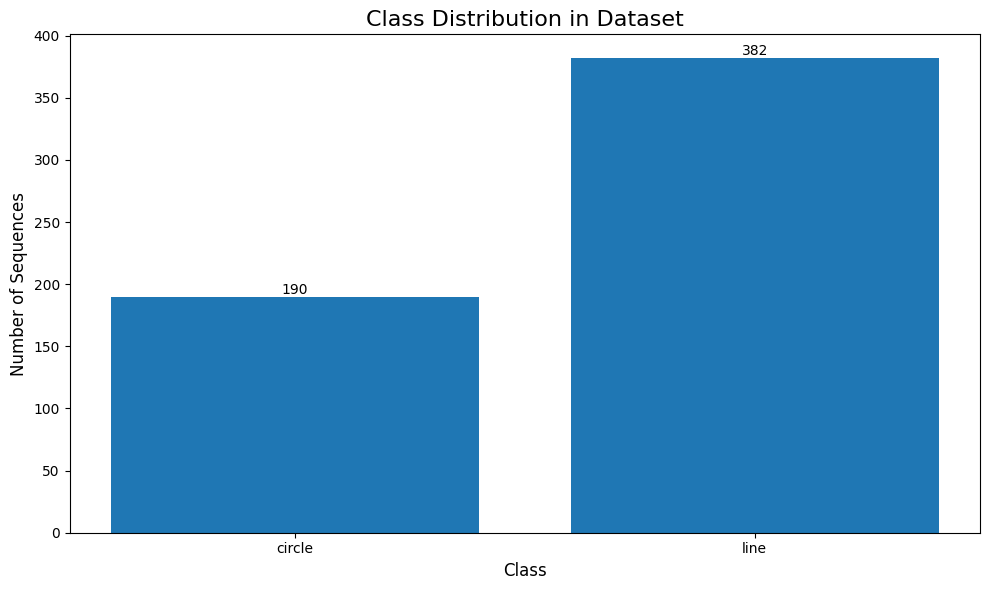

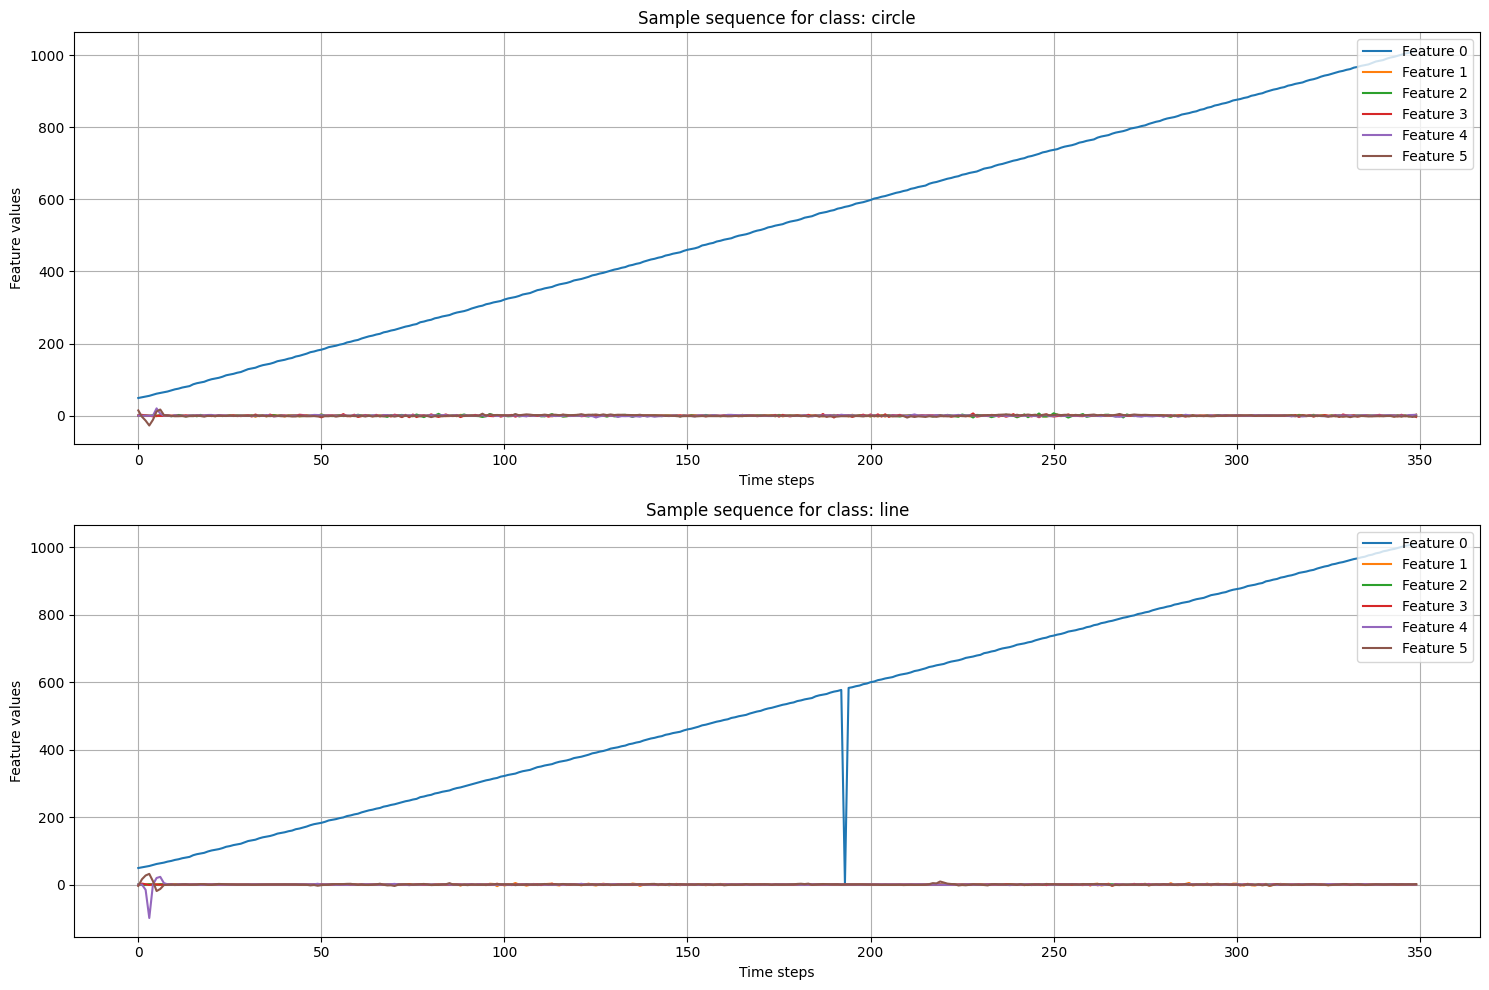

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

# Define the data directory and file paths
data_dir = "/Users/imaadbukhari/Documents/Stylus/IMU_trial"
file_paths = {
    "circle": os.path.join(data_dir, "IMU_Data_20250412_004901.csv"),
    "line1": os.path.join(data_dir, "IMU_Data_20250412_005125.csv"),  # Use unique key "line1"
    "line2": os.path.join(data_dir, "IMU_Data_20250412_005257.csv")   # Use unique key "line2"
}

# Function to process a single dataframe by calculating differences normalized by time
def vectorize_imu_data(df):
    # Ensure timestamp is in the right format
    df['Timestamp'] = pd.to_numeric(df['Timestamp'])
    
    # Create a copy to avoid modifying the original dataframe
    result_df = df.copy()
    
    # List of IMU columns to vectorize
    imu_columns = ['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ']
    
    # Calculate differences for each IMU column and normalize by time difference
    for col in imu_columns:
        # Calculate differences
        result_df[col] = df[col].diff()
        
        # Calculate time differences in seconds
        time_diff = df['Timestamp'].diff() / 1000  # Assuming timestamp is in milliseconds
        
        # Normalize by time difference (rate of change)
        # Avoid division by zero by replacing zeros with NaN and then filling with zeros
        result_df[col] = result_df[col] / time_diff.replace(0, np.nan).fillna(0)
    
    # Drop the first row as it will have NaN values after differencing
    result_df = result_df.dropna()
    
    return result_df

# Load and process each dataset
processed_dfs = {}
for key, file_path in file_paths.items():
    print(f"Processing {key} data from {file_path}")
    
    try:
        # Load the CSV file
        df = pd.read_csv(file_path)
        
        # Vectorize the data
        processed_df = vectorize_imu_data(df)
        
        # Add class label - use "line" for both line1 and line2
        final_label = "circle" if key == "circle" else "line"
        processed_df['label'] = final_label
        
        processed_dfs[key] = processed_df
        print(f"Processed {len(processed_df)} samples for {key} (label: {final_label})")
            
    except Exception as e:
        print(f"Error processing {key} data: {e}")

# Combine all processed dataframes
combined_df = pd.concat(processed_dfs.values(), ignore_index=True)

print(f"\nCombined dataframe shape: {combined_df.shape}")
print("Class distribution in combined data:")
print(combined_df['label'].value_counts())

# Extract features for normalization (excluding timestamp and label)
feature_cols = [col for col in combined_df.columns if col not in ['Timestamp', 'label']]
X = combined_df[feature_cols]

# Normalize the IMU features using StandardScaler (mean=0, std=1)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Update combined_df with normalized features
combined_df[feature_cols] = X_normalized

# Create sequences from the COMBINED dataframe, not individual dataframes
def create_sequences_from_combined(df, seq_length=800, step=150):
    sequences = []
    labels = []
    
    # Get unique class labels
    unique_labels = df['label'].unique()
    
    # For each class label
    for label in unique_labels:
        print(f"Creating sequences for label: {label}")
        # Filter the dataframe for this label
        label_df = df[df['label'] == label]
        
        # Get feature columns (all except label)
        features = label_df.drop('label', axis=1)
        
        # Create sequences with specified step size
        count = 0
        for i in range(0, len(label_df) - seq_length + 1, step):
            seq = features.iloc[i:i+seq_length].values
            sequences.append(seq)
            labels.append(label)
            count += 1
        
        print(f"Created {count} sequences for label {label}")
    
    return np.array(sequences), np.array(labels)

# Create sequences from the combined dataframe
X_sequences, y_labels = create_sequences_from_combined(combined_df, seq_length=350, step=150)

print(f"\nCreated {len(X_sequences)} total sequences of length {X_sequences.shape[1]}")
print(f"Feature dimension: {X_sequences.shape[2]}")

# Print class distribution before train/test split
from collections import Counter
print("\nClass distribution in dataset before splitting:")
print(Counter(y_labels))

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

print(f"Training sequences: {X_train.shape[0]}")
print(f"Testing sequences: {X_test.shape[0]}")

# Save the processed datasets (for sequences, we'll use numpy's save format)
output_dir = "/Users/imaadbukhari/Documents/Stylus/"

# Save sequences and labels
np.save(f"{output_dir}X_train_sequences.npy", X_train)
np.save(f"{output_dir}X_test_sequences.npy", X_test)
np.save(f"{output_dir}y_train.npy", y_train)
np.save(f"{output_dir}y_test.npy", y_test)

# Save the scaler for future use
import joblib
joblib.dump(scaler, f"{output_dir}imu_scaler.pkl")

# Display label distribution
print("\nClass distribution in training dataset:")
print(Counter(y_train))
print("\nClass distribution in testing dataset:")
print(Counter(y_test))

# Print percentages for better understanding
train_counts = Counter(y_train)
test_counts = Counter(y_test)
total_train = len(y_train)
total_test = len(y_test)
print(f"\nTraining set percentages:")
for label, count in train_counts.items():
    print(f"{label}: {count} samples ({count/total_train:.2%})")
print(f"\nTesting set percentages:")
for label, count in test_counts.items():
    print(f"{label}: {count} samples ({count/total_test:.2%})")

# Save a sample of sequences as CSV for inspection (first 5 sequences)
for i in range(min(5, len(X_train))):
    # Get feature column names (assuming they match your original feature_cols)
    if 'Timestamp' in combined_df.columns:
        cols = feature_cols + ['Timestamp']
    else:
        cols = feature_cols
    
    # Create a DataFrame for this sequence
    seq_df = pd.DataFrame(X_train[i], columns=cols)
    seq_df['label'] = y_train[i]
    seq_df.to_csv(f"{output_dir}sample_sequence_{i}_{y_train[i]}.csv", index=False)

print(f"\nSaved {min(5, len(X_train))} sample sequences as CSV files for inspection")

# Plot the class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
class_counts = Counter(y_labels)
bars = plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution in Dataset', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Sequences', fontsize=12)

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(f"{output_dir}class_distribution.png", dpi=300)
plt.show()

# Visualize a sample sequence from each class
plt.figure(figsize=(15, 10))
class_labels = np.unique(y_labels)

for i, label in enumerate(class_labels):
    # Get first sequence for this class
    class_indices = np.where(y_labels == label)[0]
    if len(class_indices) > 0:
        idx = class_indices[0]
        seq = X_sequences[idx]
        
        plt.subplot(len(class_labels), 1, i+1)
        
        # Plot all features in the sequence
        for j in range(min(6, seq.shape[1])):  # Plot up to 6 features
            plt.plot(seq[:, j], label=f'Feature {j}')
        
        plt.title(f'Sample sequence for class: {label}')
        plt.xlabel('Time steps')
        plt.ylabel('Feature values')
        plt.legend(loc='upper right')
        plt.grid(True)

plt.tight_layout()
plt.savefig(f"{output_dir}sample_sequences_by_class.png", dpi=300)
plt.show()

## Training Sequential Learning Model

X_train shape: (457, 350, 7)
X_test shape: (115, 350, 7)
y_train shape: (457,)
y_test shape: (115,)

Class distribution in training set: {'circle': 152, 'line': 305}
Class distribution in test set: {'circle': 38, 'line': 77}
Number of timesteps: 350
Number of features: 7
Number of classes: 2
Classes: ['circle' 'line']
Class weights: {0: 1.5032894736842106, 1: 0.7491803278688525}
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 346, 32)           1152      
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 173, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 169, 64)           10304     
                                                                 
 

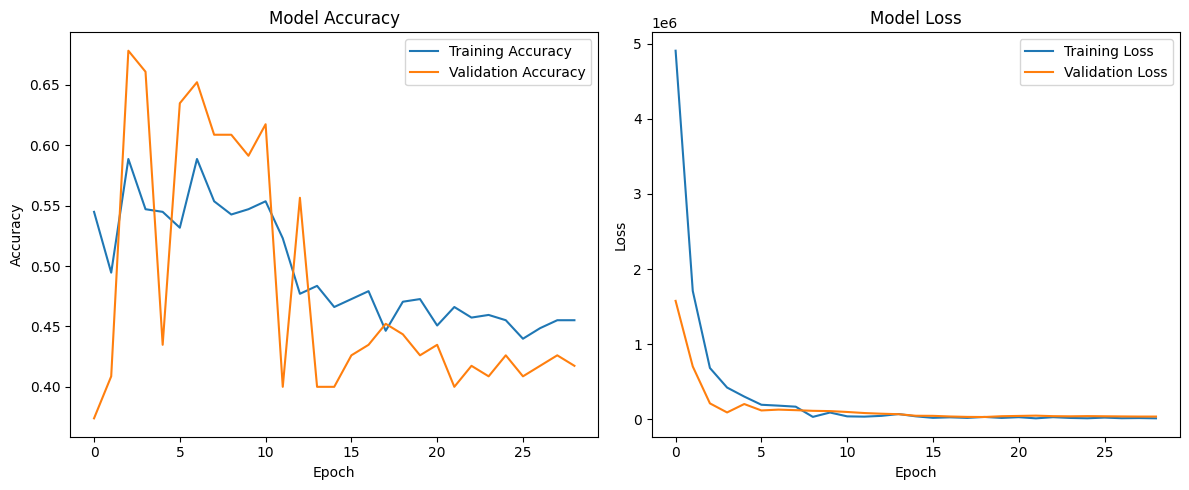

4/4 [==============================] - 0s 3ms/step


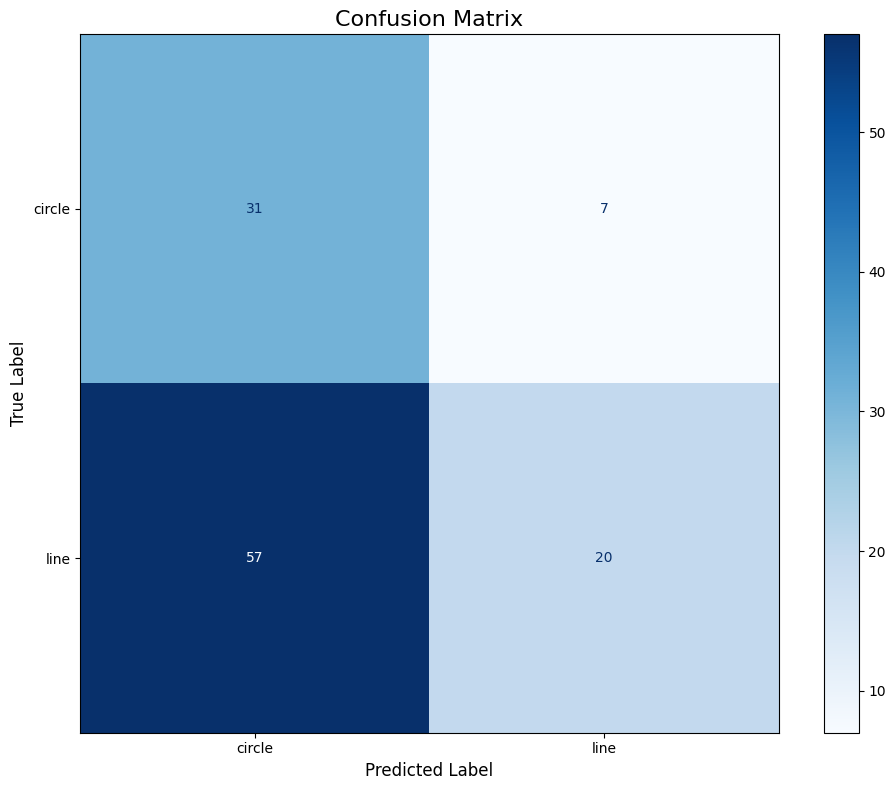

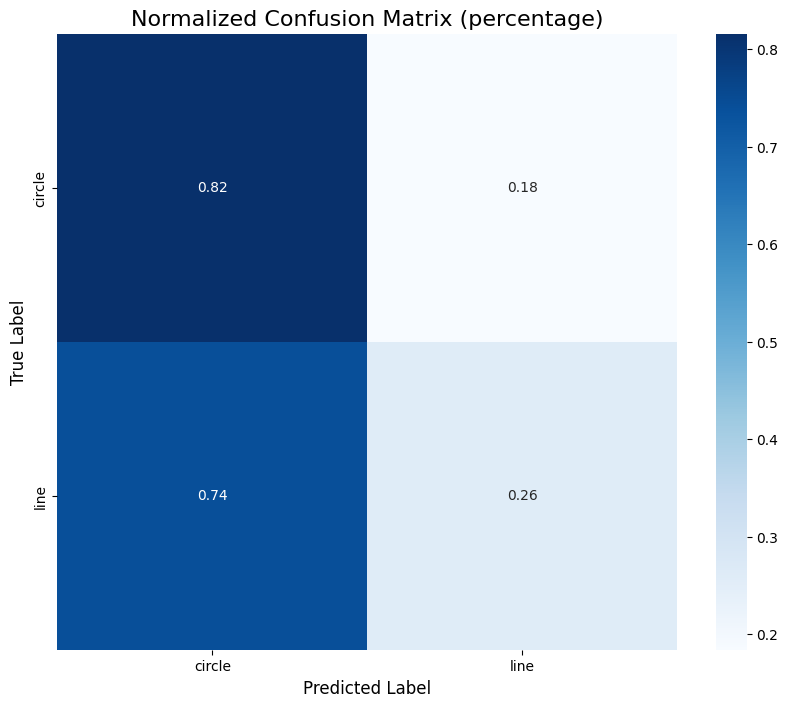


Classification Report:
              precision    recall  f1-score   support

      circle       0.35      0.82      0.49        38
        line       0.74      0.26      0.38        77

    accuracy                           0.44       115
   macro avg       0.55      0.54      0.44       115
weighted avg       0.61      0.44      0.42       115

Model and label encoder saved to /Users/imaadbukhari/Documents/Stylus/


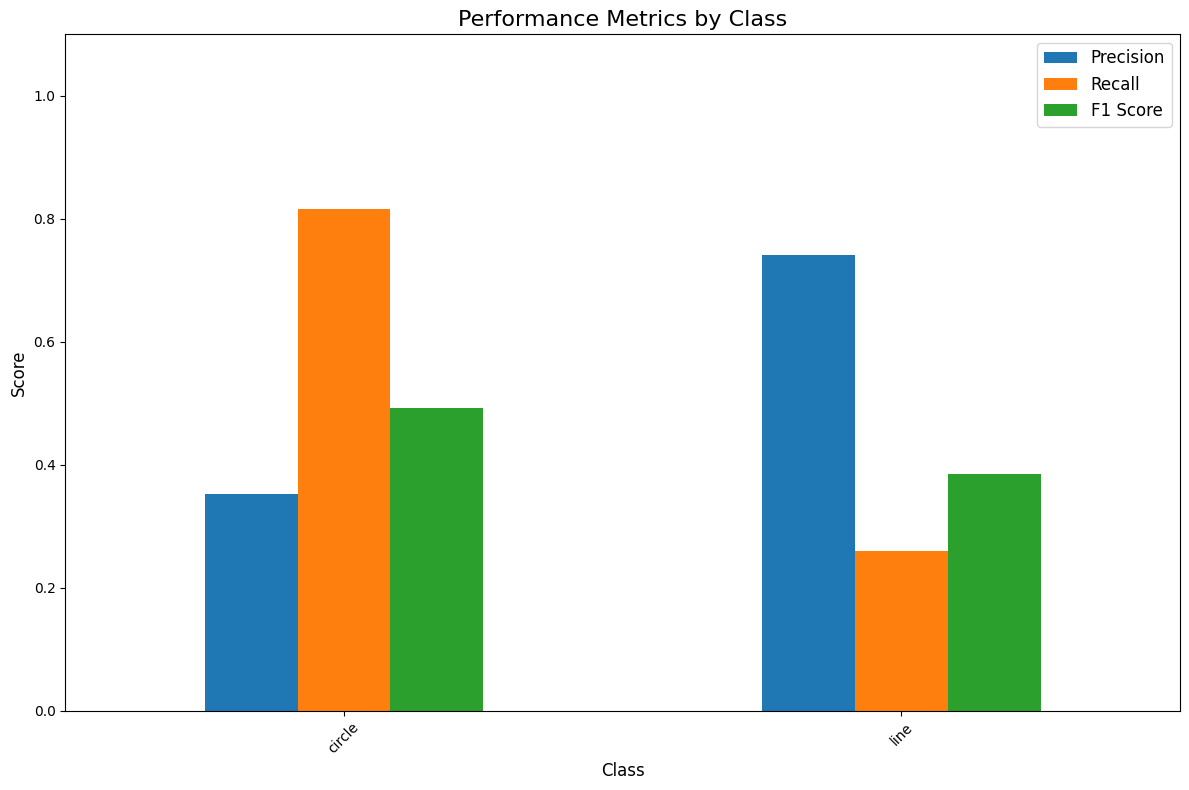


Per-class metrics:
        Precision    Recall  F1 Score  Support
circle   0.352273  0.815789  0.492063       38
line     0.740741  0.259740  0.384615       77


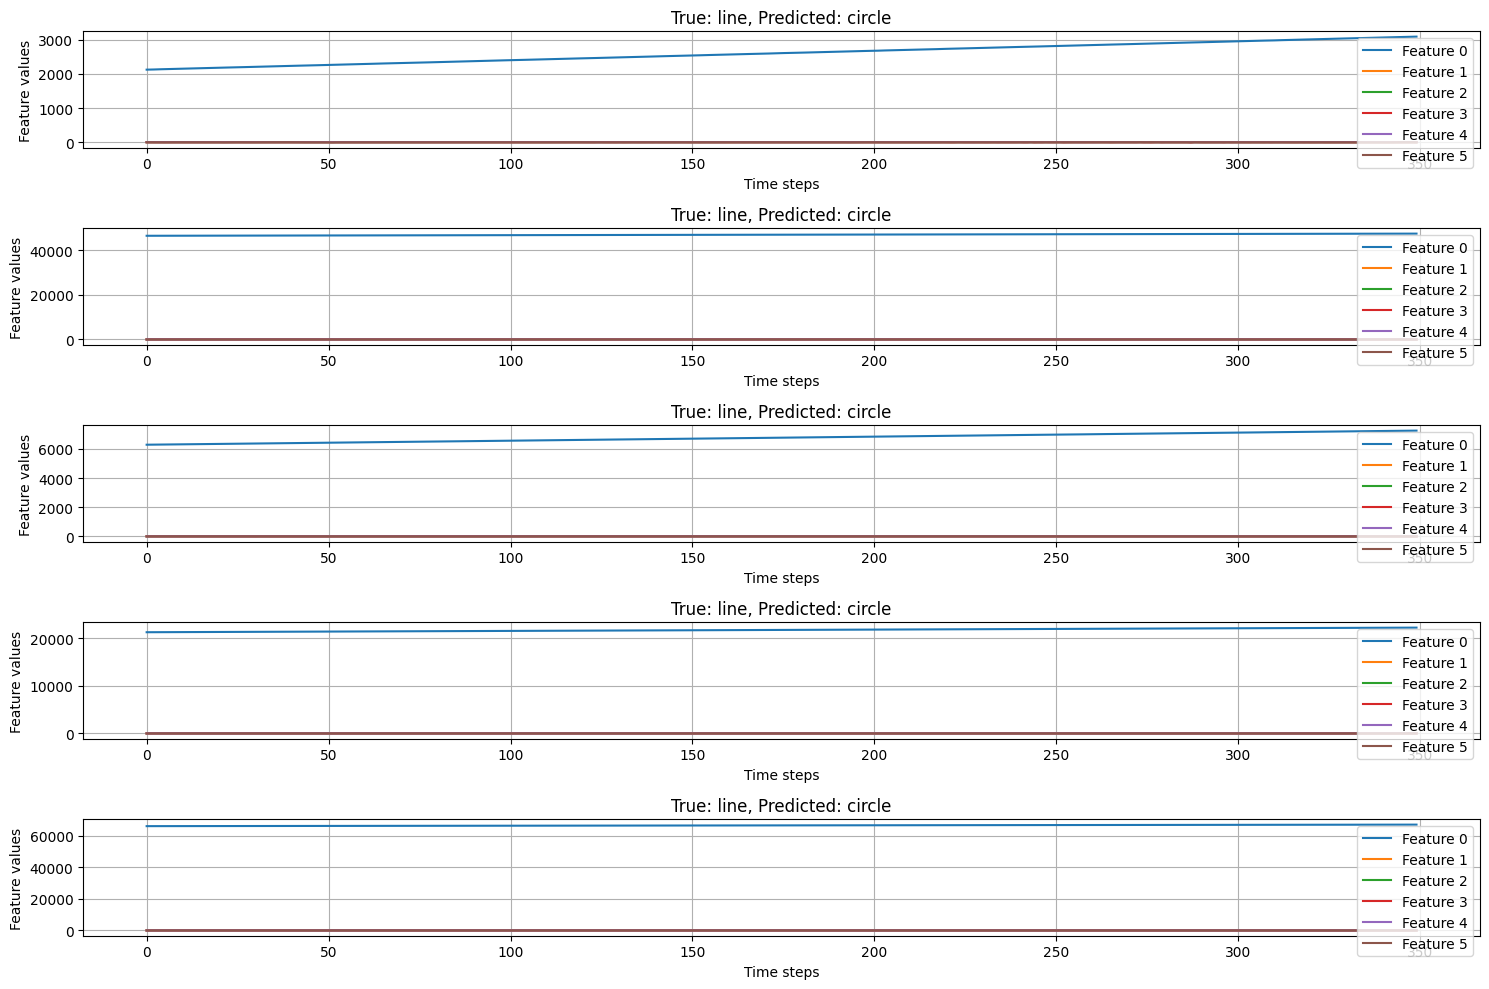

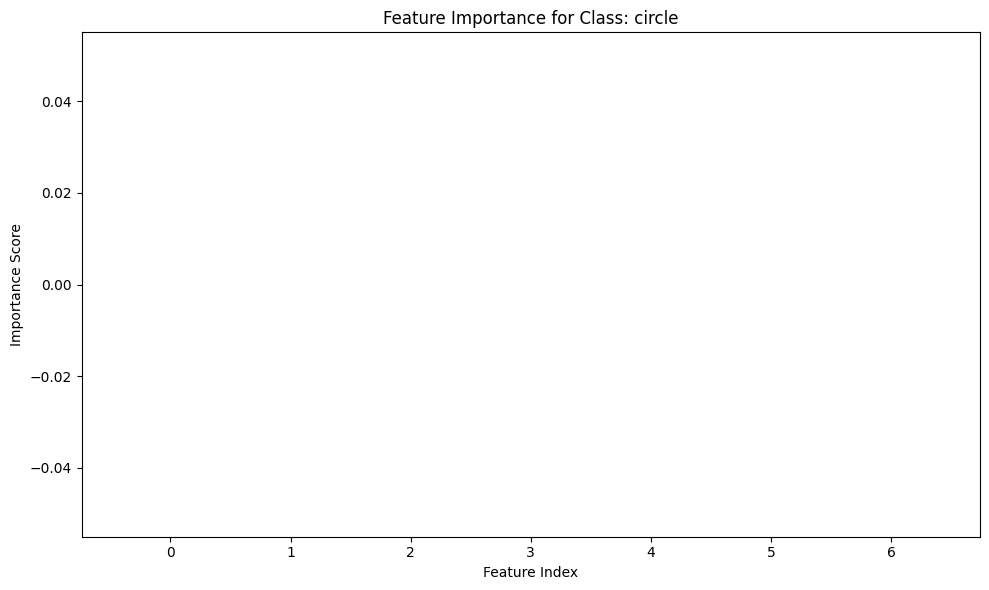

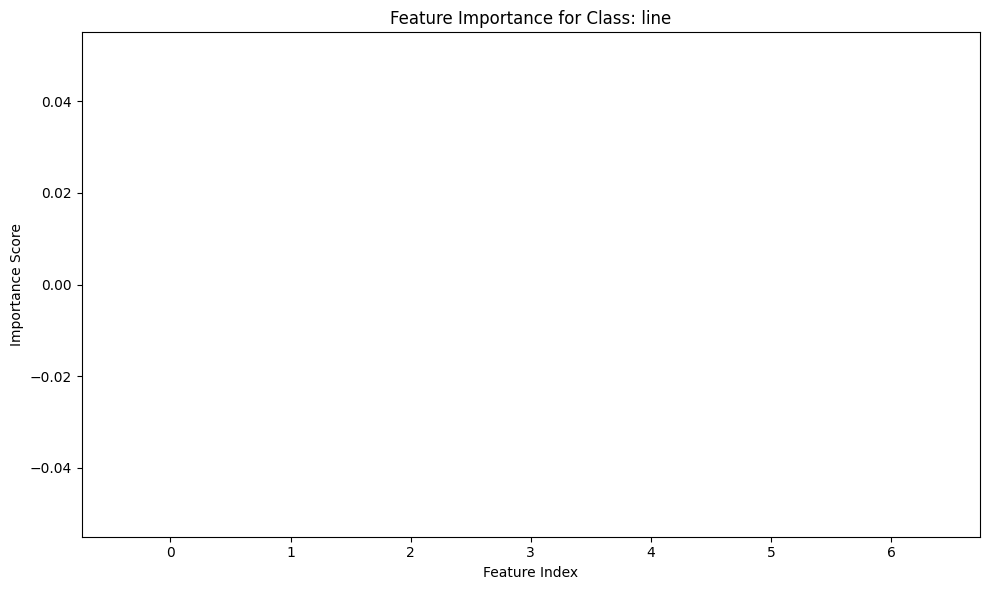

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import os
import pandas as pd

# Enable MPS (Metal Performance Shaders) acceleration for Mac
try:
    # Check if MPS is available
    if tf.config.list_physical_devices('GPU'):
        print("GPU is available")
    elif hasattr(tf.config, 'experimental') and hasattr(tf.config.experimental, 'list_physical_devices'):
        if tf.config.experimental.list_physical_devices('MPS'):
            print("MPS device found")
            # Set up MPS as the device
            tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('MPS')[0], 'MPS')
            print("Using MPS acceleration")
except Exception as e:
    print(f"Error setting up MPS: {e}")
    print("Using CPU for training")

# Load the prepared sequence data
output_dir = "/Users/imaadbukhari/Documents/Stylus/"
X_train = np.load(f"{output_dir}X_train_sequences.npy")
X_test = np.load(f"{output_dir}X_test_sequences.npy")
y_train = np.load(f"{output_dir}y_train.npy")
y_test = np.load(f"{output_dir}y_test.npy")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Class distribution to check if balanced
train_counts = dict(zip(*np.unique(y_train, return_counts=True)))
test_counts = dict(zip(*np.unique(y_test, return_counts=True)))
print("\nClass distribution in training set:", train_counts)
print("Class distribution in test set:", test_counts)

# Handle class labels - encode string labels to integers, then one-hot encode
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the integer labels
y_train_onehot = to_categorical(y_train_encoded)
y_test_onehot = to_categorical(y_test_encoded)

# Get the number of features and classes
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_classes = len(label_encoder.classes_)

print(f"Number of timesteps: {n_timesteps}")
print(f"Number of features: {n_features}")
print(f"Number of classes: {n_classes}")
print(f"Classes: {label_encoder.classes_}")

# Compute class weights to address any imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

# Define a hybrid CNN-LSTM model (better for capturing patterns in IMU data)
def create_hybrid_model():
    model = Sequential([
        # 1D CNN layers to capture local patterns
        Conv1D(filters=64, kernel_size=5, activation='relu', 
               input_shape=(n_timesteps, n_features),
               padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # Bidirectional LSTM to capture temporal dependencies
        Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Another LSTM layer
        Bidirectional(LSTM(32, return_sequences=False)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Dense layers
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Output layer
        Dense(n_classes, activation='softmax')
    ])
    
    # Compile with a lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Alternatively, create a simpler CNN model which may work better in some cases
def create_cnn_model():
    model = Sequential([
        # 1D CNN layers 
        Conv1D(32, kernel_size=5, activation='relu', input_shape=(n_timesteps, n_features)),
        MaxPooling1D(pool_size=2),
        
        Conv1D(64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        Conv1D(128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        Dense(n_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the model - use CNN model for comparison
model = create_cnn_model()  # Try using the CNN model instead
model.summary()

# Callbacks - added a shorter patience for early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint(f"{output_dir}best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

# Train the model with class weights and a smaller batch size
batch_size = 8  # Smaller batch size
epochs = 50     # More epochs with early stopping

history = model.fit(
    X_train, y_train_onehot,
    validation_data=(X_test, y_test_onehot),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weight_dict,  # Apply class weights
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig(f"{output_dir}training_history.png")
plt.show()

# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_test_encoded

# Get the class labels
class_labels = label_encoder.classes_

# Create enhanced confusion matrix visualization
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig(f"{output_dir}confusion_matrix.png", dpi=300)
plt.show()

# Calculate normalized confusion matrix (percentage)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Normalized Confusion Matrix (percentage)', fontsize=16)
plt.savefig(f"{output_dir}confusion_matrix_normalized.png", dpi=300)
plt.show()

# Classification report
print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

# Save classification report to file
with open(f"{output_dir}classification_report.txt", "w") as f:
    f.write(report)

# Save the trained model and label encoder
model.save(f"{output_dir}imu_classifier_model.keras")
import joblib
joblib.dump(label_encoder, f"{output_dir}label_encoder.pkl")
print(f"Model and label encoder saved to {output_dir}")

# Performance metrics per class
from sklearn.metrics import precision_recall_fscore_support

# Get precision, recall, f1-score for each class
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=range(len(class_labels))
)

# Create a bar chart to visualize metrics per class
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Support': support
}, index=class_labels)

# Plot bar chart
plt.figure(figsize=(12, 8))
metrics_df[['Precision', 'Recall', 'F1 Score']].plot(kind='bar', ax=plt.gca())
plt.title('Performance Metrics by Class', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(f"{output_dir}performance_by_class.png", dpi=300)
plt.show()

print("\nPer-class metrics:")
print(metrics_df)

# Visualize some of the misclassified examples
misclassified_indices = np.where(y_pred != y_true)[0]
if len(misclassified_indices) > 0:
    num_samples = min(5, len(misclassified_indices))
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(misclassified_indices[:num_samples]):
        plt.subplot(num_samples, 1, i+1)
        
        # Get the sequence
        seq = X_test[idx]
        true_label = label_encoder.inverse_transform([y_true[idx]])[0]
        pred_label = label_encoder.inverse_transform([y_pred[idx]])[0]
        
        # Plot all features in the sequence
        for j in range(min(6, n_features)):  # Plot up to 6 features
            plt.plot(seq[:, j], label=f'Feature {j}')
        
        plt.title(f'True: {true_label}, Predicted: {pred_label}')
        plt.xlabel('Time steps')
        plt.ylabel('Feature values')
        plt.legend(loc='upper right')
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}misclassified_examples.png", dpi=300)
    plt.show()
else:
    print("No misclassified examples!")

# Feature importance analysis using gradient-based methods
if n_classes == 2:  # Only for binary classification
    # Create a gradient-based feature importance model
    from tensorflow.keras.models import Model
    import tensorflow as tf
    
    # Create a gradient model
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    
    # Get a test sample from each class
    class_samples = {}
    for class_idx in range(n_classes):
        indices = np.where(y_test_encoded == class_idx)[0]
        if len(indices) > 0:
            class_samples[class_idx] = X_test[indices[0]]
    
    # Calculate feature importance using gradient-based method
    for class_idx, sample in class_samples.items():
        class_name = label_encoder.inverse_transform([class_idx])[0]
        sample_expanded = np.expand_dims(sample, axis=0)
        
        with tf.GradientTape() as tape:
            # Cast to float32
            sample_tf = tf.cast(sample_expanded, tf.float32)
            tape.watch(sample_tf)
            pred = model(sample_tf)
            pred_class = tf.argmax(pred, axis=1)[0]
            output = pred[:, pred_class]
        
        # Get gradients
        gradients = tape.gradient(output, sample_tf)
        gradients = tf.reduce_mean(tf.abs(gradients), axis=0)
        feature_importance = np.mean(gradients.numpy(), axis=0)
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(feature_importance)), feature_importance)
        plt.title(f'Feature Importance for Class: {class_name}')
        plt.xlabel('Feature Index')
        plt.ylabel('Importance Score')
        plt.tight_layout()
        plt.savefig(f"{output_dir}feature_importance_{class_name}.png", dpi=300)
        plt.show()